# Heston Model Calibration from Option Pricing

Welcome to this notebook dedicated to the calibration of two major approaches in option pricing: the Geometric Brownian Motion (GBM) and the Heston model. Calibration of these models to market data is pivotal as it facilitates accurate pricing, hedging, and risk management activities in the options trading universe.

## Dataset Structure

Before delving into the models, let's understand the structure of the dataset required by this notebook:

The dataset should comprises several columns as shown below:

In [1]:
import pandas as pd  # importing the pandas library for data manipulation and analysis

# specifying the file name for the Excel file to be read
excel_file = 'OptionData.xlsx'

# reading the data from the specified Excel file into a pandas DataFrame
df = pd.read_excel(excel_file)

# computing the 'Mid' price as the average of 'Bid' and 'Ask' prices for each row
df['Mid'] = df[['Bid','Ask']].mean(axis=1)

# extracting the first part of the 'Ticker' string before any whitespace
df['Ticker'] = df['Ticker'].str.split().str[0]

# dropping the 'IVM' column from the DataFrame
df.drop(columns='IVM', inplace=True)

# filtering the DataFrame to only include rows where 'Option_type' is "Call"
# and selecting specific columns to keep
df = df[df['Option_type'] == "Call"][['Ticker','Maturity_days', 'Strike','Bid','Ask', 'Mid','Volm']]

# displaying the first few rows of the DataFrame to see the data
df.head()

,Ticker,Maturity_days,Strike,Bid,Ask,Mid,Volm
0,AAPL,25,170.0,21.150000,21.400000,21.275000,7
1,AAPL,25,172.5,18.649994,19.049988,18.849991,0
2,AAPL,25,175.0,16.449997,16.649994,16.549995,19
3,AAPL,25,177.5,14.100000,14.400000,14.250000,0
4,AAPL,25,180.0,12.050000,12.150000,12.100000,1129


In [2]:
# displaying the last few rows of the dataframe 
df.tail()

,Ticker,Maturity_days,Strike,Bid,Ask,Mid,Volm
284,AAPL,697,210.0,16.50,18.849991,17.674995,0
285,AAPL,697,215.0,14.95,18.250000,16.600000,0
286,AAPL,697,220.0,14.25,15.100000,14.675000,20
287,AAPL,697,225.0,12.00,14.000000,13.000000,0
288,AAPL,697,230.0,10.10,13.800000,11.950000,0


In [3]:
# displaying the summary information about the DataFrame, including the data types and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 0 to 288
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         153 non-null    object 
 1   Maturity_days  153 non-null    int64  
 2   Strike         153 non-null    float64
 3   Bid            153 non-null    float64
 4   Ask            153 non-null    float64
 5   Mid            153 non-null    float64
 6   Volm           153 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 9.6+ KB


In [4]:
# getting the unique value of the 'Ticker' column and assigning the first unique value to the 'ticker' variable
ticker = df.Ticker.unique()[0]

# setting the current stock price as 190.3
current_stock_price = 190.3

# displaying the value stored in the 'ticker' variable
ticker

'AAPL'

---
- **Ticker** : This column specifies the ticker symbol of the underlying asset for the option.

- **Maturity_days** : This column indicates the number of days until the option's expiration.

- **Strike** : The predetermined price at which the underlying asset can be bought (for call options) or sold (for put options) when the option is exercised.

- **Mid** : The mid-price of the option. Calculated as the average of the bid and ask prices.

- **Bid** : The highest price a buyer is willing to pay for the option.

- **Ask** : The lowest price a seller is willing to sell the option for.

- **Volm** : Volume of the option trades for the given period. Represents the number of contracts traded.
---

> # With this kind of dataset in hand, we aim to calibrate our models to best represent the observed Call Prices

---

## 1. **Geometric Brownian Motion (GBM)**

The GBM model is one of the foundational models for option pricing, especially known for its use in the Black-Scholes formula. Under this framework, the stock price is assumed to follow a geometric Brownian motion with constant volatility, also termed as 'implied volatility'.

##### Equation
$$ dS(t) = \mu S(t) dt + \sigma S(t) dW(t) $$

### Calibration Goal:

- **Implied Volatility:** We aim to calibrate the constant volatility parameter **$\sigma$** such that the model prices are as close as possible to the observed market prices.

## 2. **Heston Model**

The Heston model, on the other hand, is a more advanced stochastic volatility model. It assumes that the volatility of the asset is not constant, nor even deterministic, but follows a random process.

##### Equation
$$ dS(t) = (r-q) S(t) dt + \sqrt{v(t)} S(t) dW_1(t) $$
$$ dv(t) = \kappa (\theta - v(t)) dt + \lambda \sqrt{v(t)} dW_2(t) $$

### Calibration Goal:

Our aim is to calibrate the model parameters, including the long-term mean volatility **$\theta$**, the mean-reversion rate **$\kappa$**, the correlation **$\rho$** between the two  Wiener processes, the initial variance **$\nu_0$**, and the volatility of the volatility parameter **$\lambda$**. 
We will leverage two different calibration methods:

- **Nelson's Gradient-Free Approach:** A sophisticated optimization technique that attempts to locate the best parameter values without the explicit need for gradient information.

- **BLSF Algorithm:** An advanced method known for its robustness in finding optimal solutions.

---

#### Importing necessary modules

In [5]:
import warnings  # importing the warnings library for controlling warning messages
warnings.filterwarnings("ignore")  # configuring the warnings to be ignored, effectively suppressing them

import numpy as np  # importing the NumPy library for numerical computations
from scipy.stats import norm  # importing the 'norm' function from scipy.stats for normal distribution calculations

import readPlotOptionSurface as ros  # importing a custom module named 'readPlotOptionSurface' with alias 'ros'

import modulesForCalibration as mfc  # importing a custom module named 'modulesForCalibration' with alias 'mfc'

from modulesForCalibration import DotPrinter  # importing the 'DotPrinter' class from the 'modulesForCalibration' custom module

import matplotlib.pyplot as plt  # importing the Matplotlib library for plotting graphs
import seaborn as sns # importing the seaborn library for plotting graphs

from scipy import optimize  # importing the 'optimize' module from scipy for optimization tasks

from scipy.optimize import fmin  # importing the 'fmin' function from scipy.optimize for minimization tasks

from scipy.optimize import fmin_bfgs  # importing the 'fmin_bfgs' function from scipy.optimize for minimization tasks

# Plotting Option Surfaces: A Detailed Insight

## Overview

When visualizing financial instruments like options, plotting option surfaces provides a comprehensive representation of the option prices in relation to the strike prices and the maturity dates. In this document, we specifically focus on creating visual representations for the company call and put options, utilizing linear interpolation to account for missing strikes, ensuring a smoother and more accurate surface.

## Objective

The main objective is to illustrate the intricacies of the company options with varying strike prices and maturity dates, enabling easier analysis of option dynamics for traders and analysts. These surface plots can give a quick visual intuition about the premium one has to pay for a given strike and maturity.

## Methodology

### Data Selection

We start by selecting specific data points:
- **Option Type**: Call or Put
- **Maturity Days**
- **Strike Price**
- **Mid Price**: (Ask + Bid) / 2

This is performed using a DataFrame where we filter the desired option type and select relevant columns.

### Defining Grid

Strikes and maturities are then sorted, and a mesh grid is created from these sorted unique strike prices and maturity days. This is crucial for constructing a well-defined 3D surface.

### Linear Interpolation

- Given the likely scenario where not all combinations of strike price and maturity have corresponding option prices, we utilize linear interpolation for generating approximations for the missing data points. 
- The `scipy.interpolate.interp1d` function is used, which computes linear interpolations of the option price, ensuring the surface plot is coherent and uninterrupted. If the data point is outside the available range, it extrapolates the values.

###




### CALL Prices: Option Surface for different Maturities and Strikes

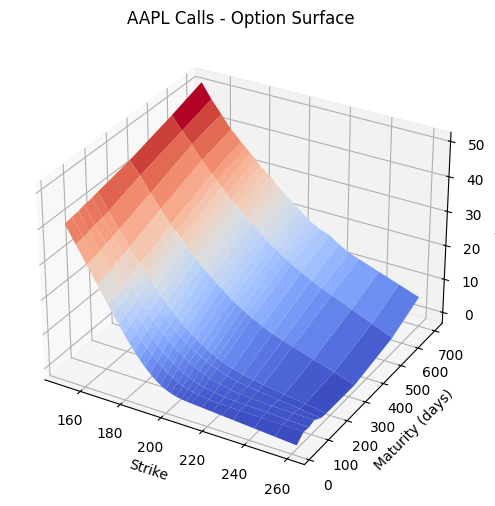

In [6]:
# calling the 'readNPlot' function from the 'ros' (readPlotOptionSurface) module, 
# passing in the DataFrame, the ticker, and the figure size, then unpacking the returned values into maturities, strikes, Prices, and fig
maturities, strikes, Prices, fig = ros.readNPlot(df, ticker, figsize=(8,6))

# Defining the parameter for the Call Option

In [7]:
K = 190  # setting the strike price of the option to 190
T_days = 151  # setting the time to expiration in days to 151
T_years = T_days / 365  # converting the time to expiration to years

# dividend rate
q = 0.005  # setting the dividend rate to 0.005

# risk free rate
r = 0.0245  # setting the risk-free interest rate to 0.0245

# spot price
S0 = current_stock_price  # setting the spot price of the stock to the variable current_stock_price

# price
P_call = 10.875  # setting the price of the call option 

## 1. **Geometric Brownian Motion (GBM) - Model Calibration: Calculating implied volatility**

In [8]:
# defining function to compute d1 for the Black-Scholes formula
def BS_d1(S, K, r, q, sigma, tau):
    ''' Computes d1 for the Black Scholes formula '''
    d1 = 1.0*(np.log(1.0 * S/K) + (r - q + sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d1  # returning the computed value of d1

# defining function to compute d2 for the Black-Scholes formula
def BS_d2(S, K, r, q, sigma, tau):
    ''' Computes d2 for the Black Scholes formula '''
    d2 = 1.0*(np.log(1.0 * S/K) + (r - q - sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d2  # returning the computed value of d2

# defining function to compute Black-Scholes price for 'call' or 'put' options
def BS_price(type_option, S, K, r, q, sigma, T, t=0):
    ''' Computes the Black Scholes price for a 'call' or 'put' option '''
    tau = T - t  # calculating time to expiration (tau)
    d1 = BS_d1(S, K, r, q, sigma, tau)  # calculating d1
    d2 = BS_d2(S, K, r, q, sigma, tau)  # calculating d2

    # calculating price for call options
    if type_option == 'Call':
        price = S * np.exp(-q * tau) * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    # calculating price for put options
    elif type_option == 'Put':
        price = K * np.exp(-r * tau) * norm.cdf(-d2) - S * np.exp(-q * tau) * norm.cdf(-d1)
    return price  # returning the calculated option price

# defining auxiliary function for computing implied volatility
def aux_imp_vol(sigma, P, type_option, S, K, r, q, T, t=0):
    ''' Auxiliary function for computing implied volatility '''
    # computing Black-Scholes price for given sigma and other parameters
    BS_P = BS_price(type_option, S, K, r, q, sigma, T, t)
    # returning the difference between the actual price and Black-Scholes price
    return P - BS_P

In [9]:
# computing implied vol
imp_vol = optimize.brentq(aux_imp_vol, 0.01, 0.4, args = (P_call, 'Call', S0, K, r, q, T_years))

In [10]:
print("Parameters:") 
print("-----------")
print(f"Strike Price (K) = {K}, Time to Expiration in Days (T_days) = {T_days}")
print(f"Time to Expiration in Years (T_years) = {T_years:.3f}, Dividend Rate (q) = {q}, Risk-free Rate (r) = {r}")
print(f"Spot Price (S0) = {S0}, Call Option Price (P_call) = {P_call}")
print("")
print("Implied Volatility:") 
print("-------------------")
print("GBM Framework - The Annualized Implied Volatility for {} is: {}".format(ticker,round(imp_vol,5)))

Parameters:
-----------
Strike Price (K) = 190, Time to Expiration in Days (T_days) = 151
Time to Expiration in Years (T_years) = 0.414, Dividend Rate (q) = 0.005, Risk-free Rate (r) = 0.0245
Spot Price (S0) = 190.3, Call Option Price (P_call) = 10.875

Implied Volatility:
-------------------
GBM Framework - The Annualized Implied Volatility for AAPL is: 0.20505


## 2. **Heston Model - Model Calibration: Finding the best parameters**

### *Starting from an initial set of parameters*

In [11]:
# specifying the model to be used as 'Heston'
model = 'Heston'

# setting the alpha parameter to 1.5
alpha = 1.5

# setting the eta parameter to 0.2
eta = 0.2

# setting the n parameter to 12
n = 12

# defining a tuple of parameters for the first set of model parameters
params1 = (1.0, 0.02, 0.05, -0.4, 0.08)

# defining a tuple of parameters for the second set of model parameters
params2 = (3.0, 0.06, 0.10, -0.6, 0.04)

# alternative sets of parameters for more aggressive or more conservative scenarios are commented out for future reference or use

# more aggressive mean reversion, higher long-term mean, higher volatility of volatility, positive correlation, higher initial volatility
# params2 = (2.5, 0.07, 0.12, 0.3, 0.1)
# lower mean reversion, lower long-term mean, lower volatility of volatility, near-zero correlation, lower initial volatility
# params2 = (0.8, 0.01, 0.03, 0.1, 0.02)

- mean-reversion rate **$\kappa$**,
- long-term mean volatility **$\theta$**,
- the volatility of the volatility parameter **$\lambda$**,
- correlation **$\rho$** between the two  Wiener processes,
- the initial variance **$\nu_0$**.

### CALL Options - Initial Parameters Scanner using the RMSE Function

To evaluate the quality of the model in fitting call option prices, we can use the Root Mean Square Error (RMSE) function.
-  The RMSE is defined as:

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (P_{\text{obs},i} - P_{\text{model},i})^2}
$$

- **$P_{\text{obs},i}$**: The observed (market) price of the ith call option.
- **$P_{\text{model},i}$**: The model-predicted price of the ith call option.
- **$N$**: The total number of observations.

### The RMSE function provides a measure of the average deviation of the model-predicted prices from the observed prices. 
### A lower RMSE value indicates a better fit.


In [12]:
# *** THIS TAKES TIME TO RUN ***

# initializing an empty list to store the 'i' values
iArray = []

# initializing an empty list to store the RMSE values
rmseArray = []

# setting an initial high value for minimum RMSE for comparison
rmseMin = 1e10  

# specifying the type of option as "Call"
option_type = "Call"

# setting the market prices based on the read Prices
marketPrices = Prices

# converting maturities to years from days
maturities_years = maturities / 365.0

# starting the animation
my_dot_printer = DotPrinter(f"\rSearching for the Initial Starting Parameters")
my_dot_printer.start()

# looping through a range of 'i' values from 0 to 1 with a step of 0.05
for i in mfc.myRange(0, 1, 0.05):
    # calculating a weighted average of params1 and params2 based on 'i'
    params = i * np.array(params1) + (1.0 - i) * np.array(params2)
    
    # appending the current value of 'i' to the iArray list
    iArray.append(i)
    
    # calculating the RMSE using the eValue function from the mfc module
    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
    
    # appending the calculated RMSE to the rmseArray list
    rmseArray.append(rmse)
    
    # checking if the calculated RMSE is less than the current minimum RMSE
    if rmse < rmseMin:
        rmseMin = rmse  # updating the minimum RMSE
        optimParams = params  # storing the parameters that resulted in the minimum RMSE

my_dot_printer.stop()
print(f"\rInitial Optimal Parameters --> Found - The optimization process will start from here", end=" " * 50)
print("")

# printing the minimum RMSE and the optimal parameters on the same line
print("Minimum RMSE: {} - Optimal Initial Parameters: {}".format(rmseMin, optimParams))

Initial Optimal Parameters --> Found - The optimization process will start from here                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

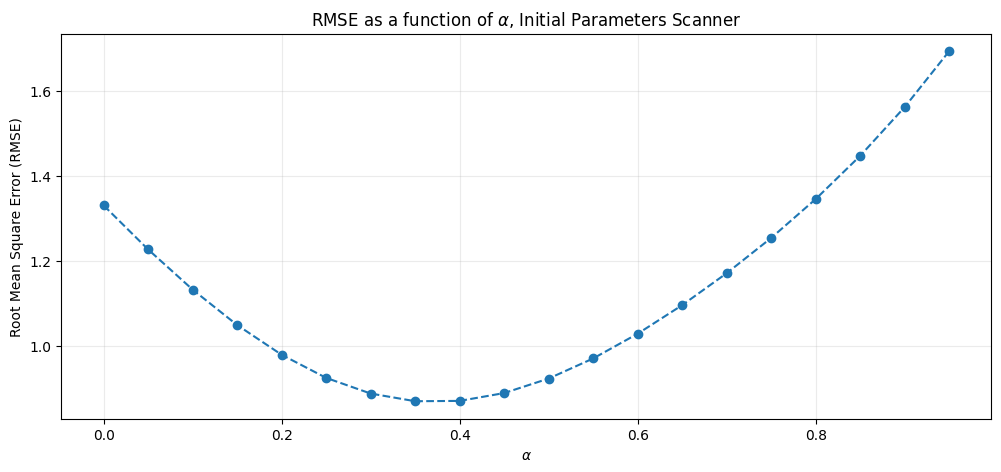

In [13]:
# creating a new figure with dimensions 15x5 for plotting
fig = plt.figure(figsize=(12,5))

# plotting the iArray against rmseArray with circle markers and dashed lines
plt.plot(iArray, rmseArray, 'o--')

# adding a grid to the plot with a transparency level set by alpha
plt.grid(alpha = 0.25)

# setting the x-axis label, using LaTeX notation for the alpha symbol
plt.xlabel(r'$\alpha$')

# setting the y-axis label to indicate the Root Mean Square Error (RMSE)
plt.ylabel('Root Mean Square Error (RMSE)')

# setting the title of the plot, again using LaTeX notation for the alpha symbol
plt.title(r'RMSE as a function of $\alpha$, Initial Parameters Scanner')

# displaying the plot
plt.show()

# **Nelson's Gradient-Free Approach** 

In [14]:
initial_guess = optimParams
initial_guess

array([ 2.3   ,  0.046 ,  0.0825, -0.53  ,  0.054 ])

In [15]:
rmseMin

0.869377254601152

### The goal now is to further reduce the root mean square error (RMSE) of the initial guess using Nelson's Gradient-Free Optimization Method.

In [16]:
# ******************************
# *** THIS TAKES TIME TO RUN ***
# ******************************

# initializing the arguments for the optimization function
arg = (marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)

# starting the animation
my_dot_printer = DotPrinter(f"\rMinimization Process - Nelson's Gradient-Free Optimization Method")
my_dot_printer.start()

# performing the optimization using the fmin function from scipy.optimize
# t contains the output including optimal parameters and function value
t = fmin(
    mfc.eValue,           # function to be minimized
    initial_guess,        # initial parameter guess, from the above cells
    args = arg,           # extra arguments passed to mfc.eValue
    maxiter = 20,         # maximum number of iterations - 20
    maxfun = 100,         # maximum number of function evaluations
    disp = True,          # flag to display convergence messages
    retall = False,       # flag to return all parameter vectors
    full_output = True    # flag to return fopt, iterations, etc. in addition to xopt
)

my_dot_printer.stop()
print(f"\rNelson's Gradient-Free Minimization Process --> Done", end=" " * 100)
print("")

# assigning the minimum RMSE and the optimal parameters
rmseMinNelson = t[1]
optimParamsNelson = t[0]

# printing the minimum RMSE and the optimal parameters on the same line
print("Minimum RMSE: {} - Optimal Nelson's Parameters: {}".format(rmseMinNelson, optimParamsNelson))

Nelson's Gradient-Free Minimization Process --> Done                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

### *Sanity Check - Using the `eValue` Function from the `modulesForCalibration` module with the `optimParamsNelson` parameters*

In [17]:
params = optimParamsNelson
rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
round(rmse,5)

0.46733

In [18]:
print(f"Improvement of {rmseMin - rmseMinNelson}, from the Initial Guess to the Nelson's Gradient-Free Method") 

Improvement of 0.4020479440300176, from the Initial Guess to the Nelson's Gradient-Free Method


# **BLSF Algorithm Approach**

In [19]:
optimParamsNelson

array([ 2.61809016,  0.04510901,  0.08576602, -0.55585804,  0.04168292])

In [20]:
rmseMinNelson

0.4673293105711344

### The goal now is to further reduce the root mean square error (RMSE) of Nelson's Gradient-Free Method using the BLSF Algorithm. This refinement  aims to improve the accuracy of the optimization.
### By reducing the RMSE, the model becomes a better fit to the observed data.

In [21]:
# ********************************
# *** THIS TAKES TIME TO RUN - ***
# ********************************

# initializing the arguments for the optimization function
arg = (marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)

# starting the animation
my_dot_printer = DotPrinter(f"\rMinimization Process - BLSF Algorithm")
my_dot_printer.start()

# performing the optimization using the fmin_bfgs function from scipy.optimize
# t contains the output including optimal parameters and function value
t = fmin_bfgs(
    mfc.eValue,              # function to be minimized
    optimParamsNelson,       # initial parameter guess - same starting point
    args=arg,                # extra arguments passed to mfc.eValue
    maxiter = 10,            # maximum number of iterations - 10
    disp = False,            # flag to display convergence messages
    retall = False,          # flag to return all parameter vectors
    full_output = True       # flag to return fopt, iterations, etc. in addition to xopt
)

my_dot_printer.stop()
print(f"\rBLSF Minimization Process --> Done", end=" " * 150)
print("")

# assigning the minimum RMSE and the optimal parameters
rmseMinBLSF = t[1]
optimParamsBLSF = t[0]

# printing the minimum RMSE and the optimal parameters on the same line
print("Minimum RMSE: {} - Optimal BLSF Parameters: {}".format(rmseMinBLSF, optimParamsBLSF))

BLSF Minimization Process --> Done                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

### *Sanity Check - Using the `eValue` Function from the `modulesForCalibration` module with the `optimParamsBLSF` parameters*

In [22]:
params = optimParamsBLSF
rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
round(rmse,5)

0.44242

In [23]:
print(f"Improvement of {rmseMinNelson - rmseMinBLSF}, from the Nelson's Algorithm to the BLSF Method") 

Improvement of 0.024909013438828453, from the Nelson's Algorithm to the BLSF Method


## Monte Carlo Simulation - Heston Model

### Parameters

- **Minimum RMSE (Root Mean Square Error)**: `0.44242029713230596`   
  The RMSE measures the quality of the calibrated Heston model. A lower value usually suggests that the model provides a better fit to the observed data.
  > ### In this instance, the average squared error amounts to roughly 44 cents.
  
- **Optimal BLSF Parameters**: `[2.72277896  0.04611148  0.09287653 -0.91985459  0.0388969]`  
  These are the parameters for the Heston model obtained from the calibration. They are used to simulate the stock price using the Heston model.

#### Parameter Values

- **$\kappa$ (mean-reversion rate)**: `2.72277896`  
  A value of around 2.72 suggests a relatively fast mean-reversion, meaning that deviations in volatility will be corrected more quickly.

- **$\theta$ (long-term mean volatility)**: `0.04611148`  
  A low value (approximately 0.0461) for the long-term mean volatility suggests that the stock is generally not very volatile.

- **$\lambda$ (volatility of volatility)**: `0.09287653`  
  A value of approximately 0.093 indicates moderate fluctuations in the volatility itself.

- **$\rho$ (correlation between the two Wiener processes)**: `-0.91985459`  
  A value close to -1 suggests a strong negative correlation between the asset price and its volatility, implying that if the asset price goes up, its volatility tends to decrease, and vice versa.

- **$\nu_0$ (initial variance)**: `0.0388969`  
  A relatively low initial variance suggests that the stock starts from a less volatile state.


### Applications

The Monte Carlo simulation using the Heston model with the given parameters can have several applications:

1. **Option Pricing**: The most common use-case for Monte Carlo simulation in the context of financial markets is option pricing. By simulating various paths that a stock's price could take, we can calculate a more accurate option price.

2. **Risk Management**: Portfolio managers can use these simulations to assess the risk associated with various trading strategies, thereby making more informed decisions.

3. **Value-at-Risk (VaR) Analysis**: This type of simulation can be used to estimate the value at risk of a portfolio, giving an idea of potential future losses in adverse market conditions.

4. **Asset Allocation**: Through simulation, one can better understand the expected returns and volatilities of different asset combinations, which is crucial for asset allocation decisions.

5. **Market Timing**: By simulating price paths, traders might identify favorable times to enter or exit the market, although this is a much more speculative use case.

6. **Regulatory Compliance**: Simulations like this can also be used to satisfy various regulatory requirements related to demonstrating the robustness of trading strategies or risk assessment methods.

> ## The RMSE is key indicators of how reliable these applications might be. Since the RMSE is relatively low, this suggests that the calibrated Heston model provides a reasonable fit to the observed data.


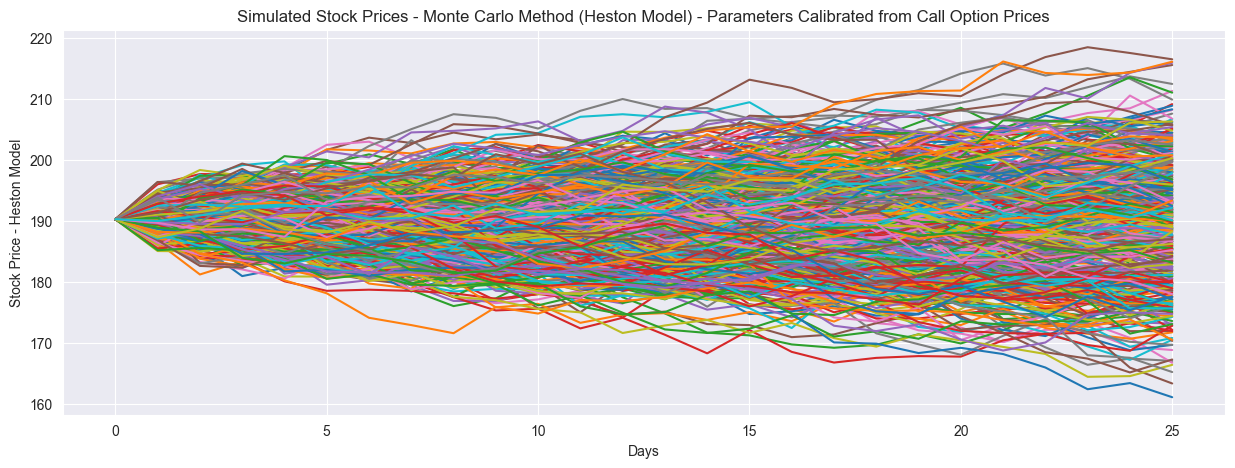

In [29]:
# initializing variables

T = 25 / 365  # converting 25 days into years 

dt = 1 / 365  # converting 1 day into years
n = int(T / dt)  # calculating the number of steps required for the simulation
N = 500  # setting the number of paths to 500
S0 = current_stock_price  # setting the initial stock price

sns.set_style("darkgrid")  # setting the plot style to whitegrid for better readability

# calibrated parameters from the BLSF Optimization Method.
# kappa, theta, sigma, rho, v0
params = optimParamsBLSF  # setting the Heston model parameters from earlier calibration

# generating multiple stock price paths
plt.figure(figsize=(15, 5))  # setting the figure size for the plot

for i in range(N):  # initiating a loop to generate N stock price paths
    S, v = [S0], [params[4]]  # initializing lists for stock price and volatility
    for t in range(1, n + 1):  # looping through each time step
        dW1 = np.sqrt(dt) * np.random.normal()  # generating a normally-distributed random variable for the volatility
        dW2 = params[3] * dW1 + np.sqrt(1 - params[3]**2) * np.sqrt(dt) * np.random.normal()  # correlating the two Brownian motions
        
        # Heston model equations
        dv = params[0] * (params[1] - v[-1]) * dt + params[2] * np.sqrt(v[-1]) * dW1  # calculating the change in volatility
        ds = np.sqrt(v[-1]) * S[-1] * dW2  # calculating the change in stock price
        
        v.append(v[-1] + dv)  # updating the volatility list
        S.append(S[-1] + ds)  # updating the stock price list
        
    plt.plot(S)  # plotting the stock price path

# Setting plot titles and labels
plt.title('Simulated Stock Prices - Monte Carlo Method (Heston Model) - Parameters Calibrated from Call Option Prices',
          fontsize = 12)  # setting the plot title
plt.xlabel('Days')  # setting the x-axis label
plt.ylabel('Stock Price - Heston Model')  # setting the y-axis label
plt.show()  # displaying the plot